<a href="https://colab.research.google.com/github/Sachin20010517/pneumonet-cnn-classifier/blob/main/PneumoNet_Complete_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name: **Rammini Sachin Ayeshmantha De Silva Dharmawickrama**









UoW id: **w1953261**

# ***PneumoNet: Deep Learning for Pneumonia Detection***

<h2>Part A – Application area review.</h2>
<h4><u>Literature Review: AI Applications in Medical Image Analysis for Pneumonia Detection </u></h4>
<br/>
<h4><b>Introduction</b></h4>
<br/>
<p style="text-align:justify">
Artificial intelligence (AI) has revolutionised medical diagnostics, particularly in radiology where deep learning algorithms demonstrate remarkable capabilities in detecting diseases from medical images. Pneumonia, a leading cause of mortality globally with approximately 2.5 million deaths annually (World Health Organization, 2023), presents a significant diagnostic challenge, particularly in resource-constrained settings. This literature review explores how AI, specifically deep learning techniques, has been applied to pneumonia detection from chest X-rays, examining the evolution of approaches, their effectiveness, and clinical implications.
<br/><br/>
<h4><b>Evolution of AI in Medical Image Analysis</b></h4>
<br/>
<p style="text-align:justify">
The application of AI to medical imaging has progressed significantly since the introduction of computer-aided diagnosis (CAD) systems in the 1980s. Traditional machine learning approaches relied heavily on manual feature engineering, requiring domain experts to define relevant image characteristics (Suzuki, 2017). However, the advent of deep learning, particularly Convolutional Neural Networks (CNNs), has transformed medical image analysis by enabling automatic feature extraction directly from raw image data (Litjens et al., 2017).
<br/><br/>
CNNs have become the predominant architecture for medical image classification due to their ability to learn hierarchical representations of visual patterns. The breakthrough work by Krizhevsky, Sutskever and Hinton (2012) with AlexNet demonstrated that deep CNNs could achieve superior performance in image recognition tasks, paving the way for their application in medical domains. Subsequent architectures such as ResNet (He et al., 2016), DenseNet (Huang et al., 2017), and EfficientNet (Tan and Le, 2019) have further enhanced classification accuracy whilst addressing challenges such as vanishing gradients and computational efficiency.
<br/><br/>


Import Libraries

In [ ]:
# data processing, CSV & image file I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy as np

#libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#preprocessing, modeling & Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive

In [ ]:
print(tf.__version__)

2.19.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Data Loading

In [ ]:
#Mount Google Drive
drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/FYP/pneumonia-Xray-dataset.zip" -d /content/



Streaming output truncated to the last 5000 lines.
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0439-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0440-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0441-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0442-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0444-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0445-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0446-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MACOSX/chest_xray/train/NORMAL/._IM-0447-0001.jpeg  
  inflating: /content/pneumonia-Xray-dataset/chest_xray/__MAC

In [ ]:
#Set my dataset paths
main_path = "/content/pneumonia-Xray-dataset/chest_xray"
os.listdir(main_path)

['val', '__MACOSX', 'test', 'train', 'chest_xray']

In [ ]:
train_dir = os.path.join(main_path, 'train')
val_dir = os.path.join(main_path, 'val')
test_dir = os.path.join(main_path, 'test')

In [ ]:
def count_file(dir=None, labels=None):
    for label in labels:
        num_data = len(os.listdir(os.path.join(dir, label)))
        print(f'number of {label} : {num_data}')

labels = ['PNEUMONIA', 'NORMAL']

print('Train Set: \n' + '='*50)
count_file(train_dir, labels)

print('\nValidation Set: \n' + '='*50)
count_file(val_dir, labels)

print('\nTest Set: \n' + '='*50)
count_file(test_dir, labels)


Train Set: 
number of PNEUMONIA : 3875
number of NORMAL : 1341

Validation Set: 
number of PNEUMONIA : 8
number of NORMAL : 8

Test Set: 
number of PNEUMONIA : 390
number of NORMAL : 234


Notice that there are significantly more images classified as pneumonia than normal. This indicates that our dataset is imbalanced. We will address this imbalance later in this notebook.

In [ ]:
def get_file_sizes(directory):
    """Collect the size (in KB) of every file within a directory tree."""

    sizes = []

    # Traverse all subdirectories and files
    for root, _, files in os.walk(directory):
        for filename in files:
            path = os.path.join(root, filename)
            size_kb = os.path.getsize(path) / 1024  # convert bytes to KB
            sizes.append({
                'file': path,
                'size_kb': round(size_kb, 3)
            })

    return sizes

In [ ]:
get_file_sizes(train_dir)[:5]

[{'file': '/content/pneumonia-Xray-dataset/chest_xray/train/NORMAL/NORMAL2-IM-0443-0001.jpeg',
  'size_kb': 730.122},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/NORMAL/NORMAL2-IM-1109-0001.jpeg',
  'size_kb': 467.184},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/NORMAL/NORMAL2-IM-1350-0001.jpeg',
  'size_kb': 502.385},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/NORMAL/NORMAL2-IM-1247-0001.jpeg',
  'size_kb': 506.609},
 {'file': '/content/pneumonia-Xray-dataset/chest_xray/train/NORMAL/NORMAL2-IM-0870-0001.jpeg',
  'size_kb': 487.781}]

Next, we will create a dataframe to make it easier to analyze the image sizes and the class distribution.

In [ ]:
def create_dataframe(path=None, labels=None):
    """
    Build a dataframe containing file paths and sizes (in KB)
    for all images within the specified class folders.
    """

    records = []

    for label in labels:
        class_dir = os.path.join(path, label)
        sizes = get_file_sizes(class_dir)
        records.extend(sizes)

    return pd.DataFrame(records)

In [ ]:
# Create dataframes for each dataset split
train_df = create_dataframe(train_dir, labels)
test_df  = create_dataframe(test_dir, labels)
val_df   = create_dataframe(val_dir, labels)

# Display the shape of each dataframe
print("Train set shape:", train_df.shape)
print("Test set shape:",  test_df.shape)
print("Validation set shape:", val_df.shape)


Train set shape: (5216, 2)
Test set shape: (624, 2)
Validation set shape: (16, 2)


In [ ]:
train_df.head(3)

,file,size_kb
0,/content/pneumonia-Xray-dataset/chest_xray/tra...,56.750
1,/content/pneumonia-Xray-dataset/chest_xray/tra...,47.001
2,/content/pneumonia-Xray-dataset/chest_xray/tra...,181.480


In [ ]:
def extract_label(file_path):
    """
    Determine the class label based on the file path.
    Returns 'pneumonia', 'normal', or 'unknown' if no match is found.
    """
    if "PNEUMONIA" in file_path:
        return "pneumonia"
    elif "NORMAL" in file_path:
        return "normal"
    else:
        return "unknown"


# Dictionary mapping dataset splits to their corresponding dataframes
dict_dir_df = {
    "train": train_df,
    "val":   val_df,
    "test":  test_df
}


In [ ]:
# Assign class labels to each dataframe based on file paths
for df in dict_dir_df.values():
    df["label"] = df["file"].apply(extract_label)

In [ ]:
train_df.sample(3)

,file,size_kb,label
1897,/content/pneumonia-Xray-dataset/chest_xray/tra...,77.677,pneumonia
877,/content/pneumonia-Xray-dataset/chest_xray/tra...,259.996,pneumonia
4503,/content/pneumonia-Xray-dataset/chest_xray/tra...,283.940,normal


In [ ]:
def get_image_dimensions(file_path):
    """
    Return the (width, height) of an image.
    If the image cannot be opened, return (0, 0).
    """
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)  # Default value if the image cannot be read


In [ ]:
# Add image dimensions (width, height) to each dataframe
for split_name, df in dict_dir_df.items():
    df["dimensions"] = df["file"].apply(get_image_dimensions)

In [ ]:
# Filter rows where the 'dimensions' tuple has a length of at least 3
for split_name, df in dict_dir_df.items():
    filtered_df = df[df["dimensions"].apply(lambda x: len(x) >= 3)]
    print(f"{split_name}: {filtered_df.shape[0]}")

train: 0
val: 0
test: 0


In [ ]:
train_df.sample(3)

,file,size_kb,label,dimensions
318,/content/pneumonia-Xray-dataset/chest_xray/tra...,169.328,pneumonia,"(1464, 1216)"
4221,/content/pneumonia-Xray-dataset/chest_xray/tra...,1749.271,normal,"(2566, 2321)"
5028,/content/pneumonia-Xray-dataset/chest_xray/tra...,600.522,normal,"(1840, 1507)"


We can observe that the images in this dataset contain only two dimensions—height and width. This indicates that the images can be treated as grayscale.

In [ ]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


The validation set contains only 16 images, which is too small for reliable evaluation. Therefore, we will combine all images from the train, validation, and test folders, then perform a new split using a 70:15:15 ratio — allocating 70% for training, 15% for validation, and 15% for testing.

In [ ]:
merged_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [ ]:
# First split: 70% train, 30% temp (test + val)
train_df, test_df_full = train_test_split(
    merged_df,
    test_size=0.3,
    stratify=merged_df['label'],
    random_state=42
)

# Second split: split the 30% into 15% test and 15% val
test_df, val_df = train_test_split(
    test_df_full,
    test_size=0.5,
    stratify=test_df_full['label'],
    random_state=42
)


In [ ]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


Exploratory Data Analysis (EDA)

In [ ]:
# Create a subplot layout with two panels: one for a bar chart and one for a pie chart
fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'xy'}, {'type': 'domain'}]]
)

# --- Bar Chart ---
bar_chart = go.Figure(
    go.Bar(
        x=train_df['label'].value_counts().index,
        y=train_df['label'].value_counts().values,
        marker_color=['#fe346e', '#2c003e']
    )
)
fig.add_trace(bar_chart['data'][0], row=1, col=1)

# --- Pie Chart ---
pie_chart = go.Figure(
    go.Pie(
        labels=train_df['label'].value_counts().index,
        values=train_df['label'].value_counts().values,
        marker=dict(
            colors=['#fe346e', '#2c003e'],
            line=dict(color='gray', width=3)
        ),
        pull=[0.05, 0]  # Exploded slice effect
    )
)
fig.add_trace(pie_chart['data'][0], row=1, col=2)

# --- Layout Configuration ---
fig.update_layout(
    showlegend=False,  # Hide legend (optional)
    title='Distribution of Diagnoses in the Training Set',
    title_x=0.5,       # Center the title
    shapes=[
        dict(
            type='line',
            x0=0.5, y0=0,
            x1=0.5, y1=1,
            line=dict(color='black', width=2)
        )
    ]
)

fig.show()


In [ ]:
# Calculate the average image height and width
height_mean = train_df['dimensions'].apply(lambda x: x[0]).mean()
width_mean = train_df['dimensions'].apply(lambda x: x[1]).mean()

print(f"The average image height is {height_mean:.2f} pixels")
print(f"The average image width is {width_mean:.2f} pixels")


The average image height is 1326.16 pixels
The average image width is 968.92 pixels


In [ ]:
# Display the minimum file size for each dataset split
dict_dir_df = {
    'train': train_df,
    'val': val_df,
    'test': test_df
}

for split_name, df in dict_dir_df.items():
    print(f"Minimum file size in the {split_name} set: {df['size_kb'].min()} KB")


Minimum file size in the train set: 5.387 KB
Minimum file size in the val set: 5.313 KB
Minimum file size in the test set: 5.921 KB


Images with very small file sizes are more likely to produce inaccurate predictions, especially when the files have been compressed and important visual details may have been lost.”

In [ ]:
# Display the maximum file size for each dataset split
for split_name, df in dict_dir_df.items():
    print(f"Maximum file size in the {split_name} set: {df['size_kb'].max()} KB")


Maximum file size in the train set: 2278.475 KB
Maximum file size in the val set: 2357.756 KB
Maximum file size in the test set: 2074.266 KB


In [ ]:
# Extract image height and width values from the "dimensions" column
heights, widths = zip(*train_df['dimensions'])

# Create a boxplot comparing height and width distributions
fig = px.box(
    x=['Height'] * len(heights) + ['Width'] * len(widths),
    y=list(heights) + list(widths),
    labels={'x': 'Dimension Type', 'y': 'Pixels'},
    points='outliers',
    title="Boxplot of Image Dimensions (Height and Width)"
)

# Customize marker appearance
fig.update_traces(
    marker_color='#fe346e',
    marker_line_color='#fe346e',
    marker_line_width=1,
    opacity=1
)

fig.show()


In [ ]:
def plot_images(image_paths, label, nrows=2, ncols=5):
    # Create a grid of subplots for displaying sample images
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))

    # Flatten axes if it's a 2D array, for easier iteration
    axes = axes.flatten()

    # Determine the actual number of images to display
    num_images_to_display = min(len(image_paths), nrows * ncols)

    for i in range(num_images_to_display):
        img = Image.open(image_paths[i])
        axes[i].imshow(img, cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f"{label}\nShape: {img.size}")

    # Turn off any remaining empty subplots
    for i in range(num_images_to_display, len(axes)):
        axes[i].axis('off')

    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()
# def plot_images(image_paths, label, nrows=2, ncols=5):
#     # Create a grid of subplots for displaying sample images
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 7))
#     num_images = nrows * ncols

#     for i in range(num_images):
#         img = Image.open(image_paths[i])
#         row_idx, col_idx = divmod(i, ncols)

#         axes[row_idx, col_idx].imshow(img, cmap='gray')
#         axes[row_idx, col_idx].axis('off')
#         axes[row_idx, col_idx].set_title(f"{label}\nShape: {img.size}")

#     plt.show()

# Retrieve file paths for each class
pneumonia_paths = train_df.query("label == 'pneumonia'")['file'].values
normal_paths    = train_df.query("label == 'normal'")['file'].values


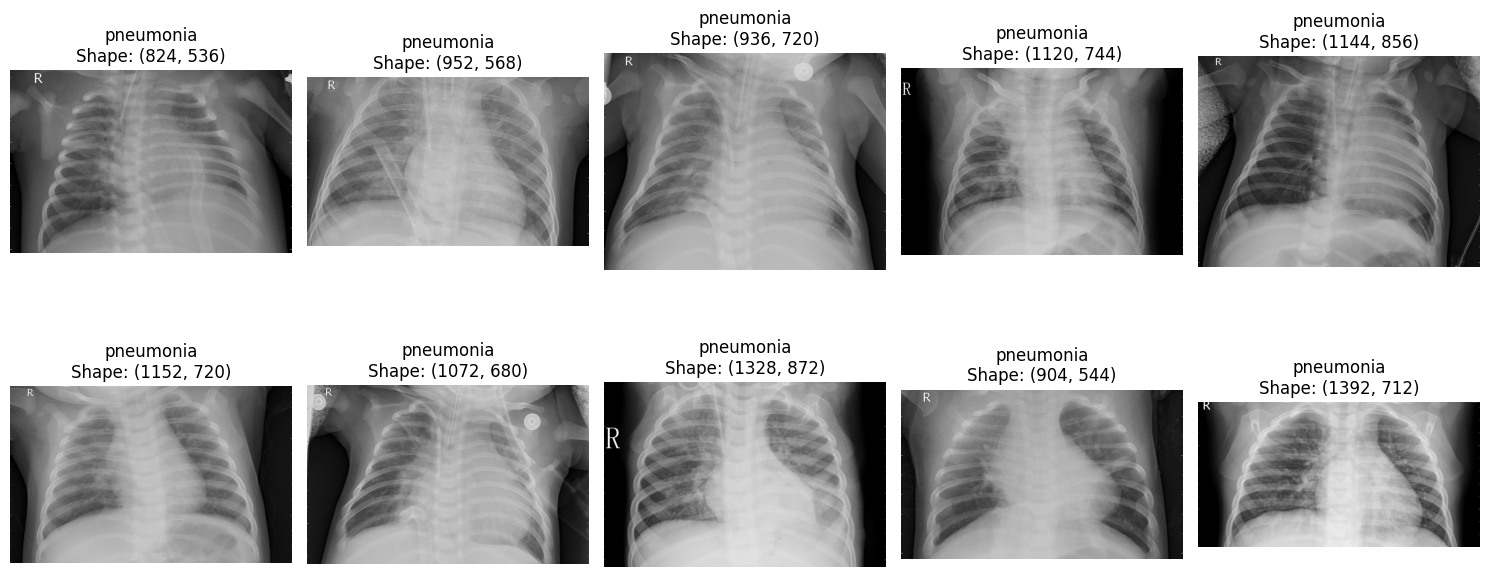

In [ ]:
# Display sample pneumonia images using the plot_images function
plot_images(pneumonia_paths, 'pneumonia')

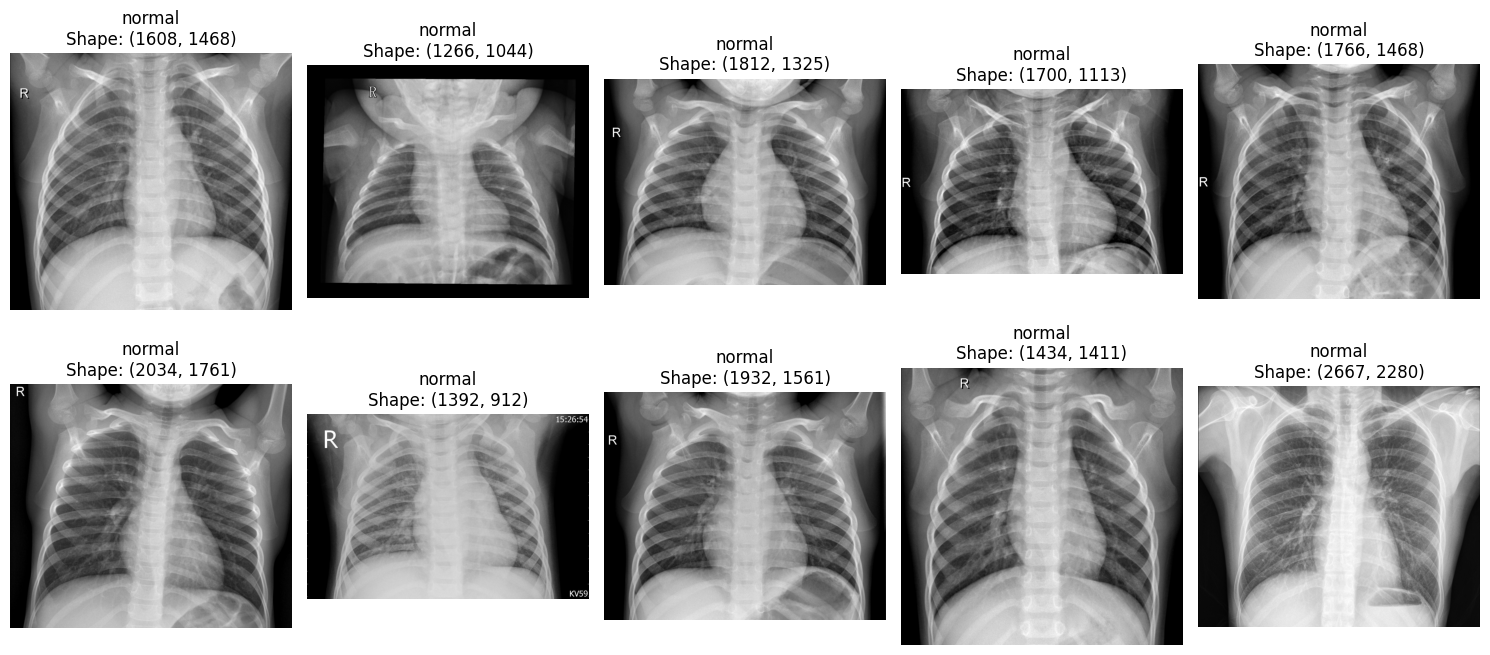

In [ ]:
plot_images(normal_paths, 'normal')

In [ ]:
# Filter training data to include only images smaller than 10 KB
filtered_pneumonia_path = train_df.query("label == 'pneumonia' and size_kb < 10")['file'].values
filtered_normal_path    = train_df.query("label == 'normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_path))
print(len(filtered_normal_path))


27
0


In [ ]:
# Filter the test dataset to include only images smaller than 10 KB
filtered_pneumonia_test = test_df.query("label == 'pneumonia' and size_kb < 10")['file'].values
filtered_normal_test    = test_df.query("label == 'normal' and size_kb < 10")['file'].values

print(len(filtered_pneumonia_test))
print(len(filtered_normal_test))


6
0


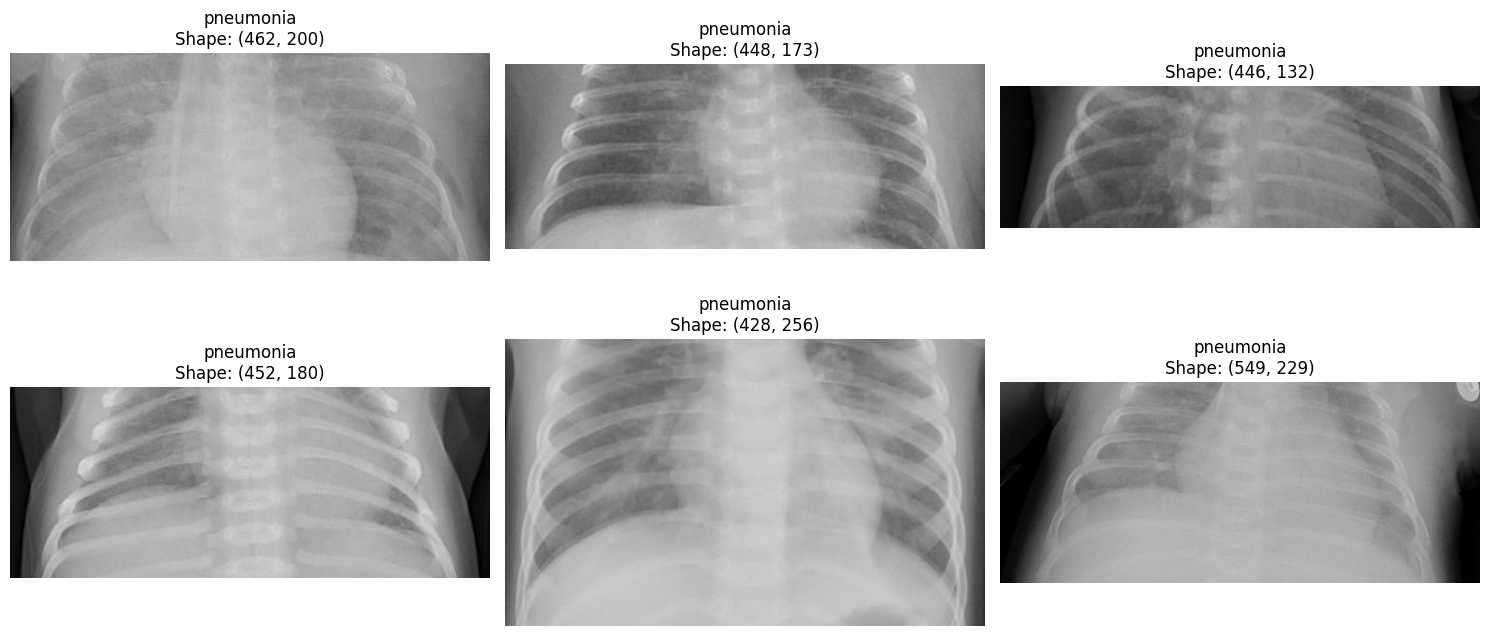

In [ ]:
# Display a 2×3 grid of pneumonia images using the plot_images function
plot_images(filtered_pneumonia_path, 'pneumonia', nrows=2, ncols=3)


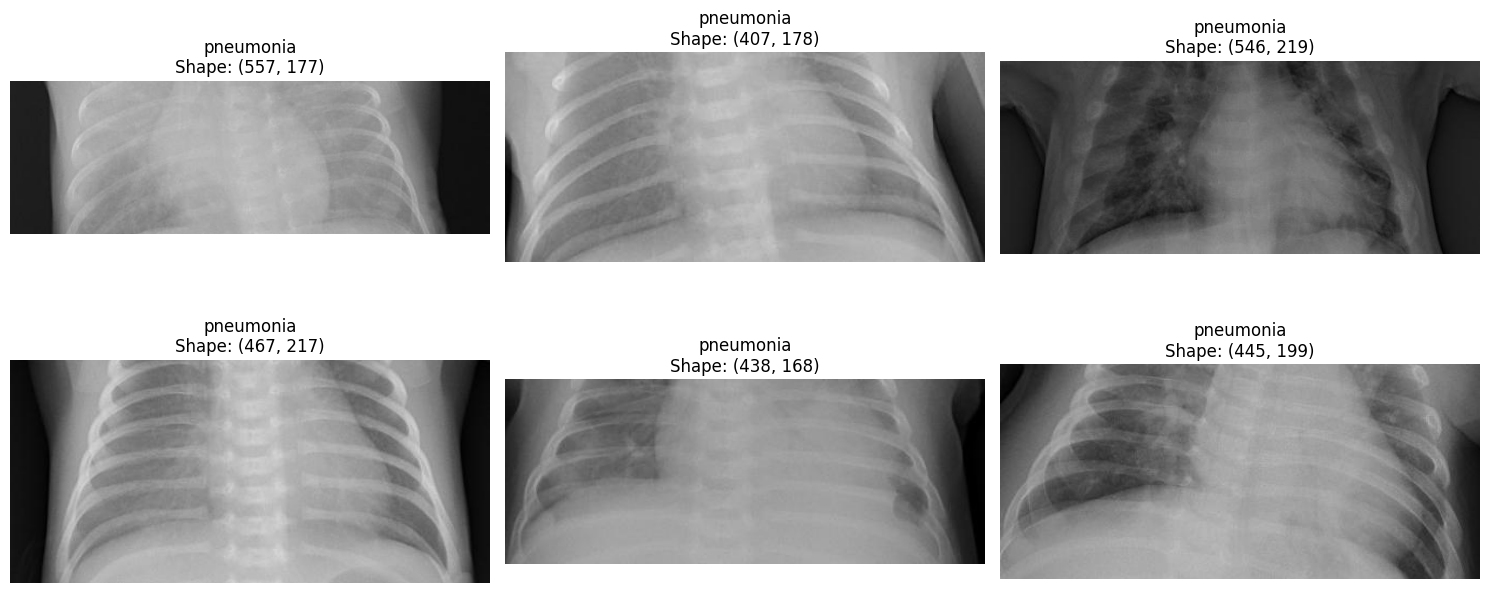

In [ ]:
plot_images(filtered_pneumonia_test, 'pneumonia', nrows=2, ncols=3)

From the visualization results, several observations can be made:
    

*   Some images appear slightly tilted either to the left or right.
*   A number of images include visible hands or the patient’s chin.
*   Several images seem partially cropped, which is consistent with their file sizes being below 10 KB.
*   There are images that appear noticeably brighter or darker than others.


Based on these findings, the preprocessing stage will likely require data augmentation techniques such as random rotation, zoom adjustments, and potentially color jitter to improve robustness.



In [ ]:
pneumonia_paths

array(['/content/pneumonia-Xray-dataset/chest_xray/test/PNEUMONIA/person78_bacteria_381.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person604_bacteria_2462.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person41_bacteria_206.jpeg',
       ...,
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person536_bacteria_2259.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1019_virus_1707.jpeg',
       '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1124_bacteria_3065.jpeg'],
      dtype=object)

In [ ]:
# Split the file path into its directory components using the system path separator
tf.strings.split('/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg',
                 os.path.sep)


<tf.Tensor: shape=(8,), dtype=string, numpy=
array([b'', b'kaggle', b'input', b'chest-xray-pneumonia', b'chest_xray',
       b'train', b'PNEUMONIA', b'person1180_virus_2010.jpeg'],
      dtype=object)>

# Data Preprocessing

In [ ]:
def preprocess_image(file_path, label, channels=3):
    # Read the image file
    img = tf.io.read_file(file_path)

    # Decode the JPEG image into a tensor
    img = tf.image.decode_jpeg(img, channels=channels)

    # Resize the image to match the model's input requirements
    img = tf.image.resize(img, [224, 224])

    # Normalize pixel values to the range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Convert labels to numeric format (0 = normal, 1 = pneumonia)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)

    return img, label


Next, we will examine the results of applying color jitter augmentation to determine whether it improves the model’s performance or potentially degrades it. Since color jitter operates on RGB images, we need to ensure that the input is processed with channels=3.

In [ ]:
def color_jitter(image, brightness_factor=0.02, contrast_factor=0.02, seed=None):
    # Apply random brightness adjustment
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)

    # Apply random contrast adjustment
    image = tf.image.random_contrast(
        image,
        lower=1 - contrast_factor,
        upper=1 + contrast_factor,
        seed=seed
    )

    # Apply random saturation adjustment
    image = tf.image.random_saturation(
        image,
        lower=1 - contrast_factor,
        upper=1 + contrast_factor,
        seed=seed
    )

    # Apply random hue adjustment
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)

    return image


In [ ]:
def visualize(original, augmented):
    # Create a side‑by‑side comparison of the original and augmented images
    fig = plt.figure()

    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original)

    plt.subplot(1, 2, 2)
    plt.title("Augmented Image")
    plt.imshow(augmented)


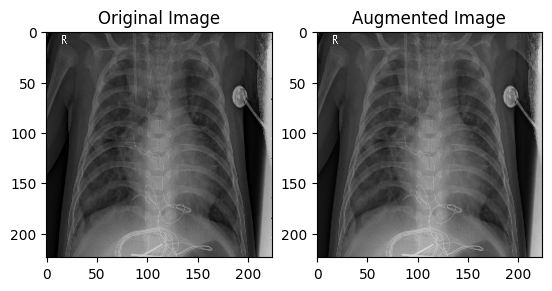

In [ ]:
# Load an example pneumonia image and apply preprocessing
image_path = '/content/pneumonia-Xray-dataset/chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path, 'pneumonia', channels=3)

# Apply color jitter augmentation for testing
color_jitter_test = color_jitter(img, seed=3)

# Visualize the original image alongside its augmented version
visualize(img, color_jitter_test)


In [ ]:
img.shape

TensorShape([224, 224, 3])

In [ ]:
number = train_df.shape[0]
factors = []

# Loop to identify all divisors of the value
for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)

# Print the list of divisors
print("The divisors of", number, "are:", factors)


The divisors of 4099 are: [1, 4099]


In [ ]:
# Constant used to enable automatic performance optimization for the dataset pipeline
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Batch size used during model training
batch_size = 32


Notes:

*   **AUTOTUNE**:  A constant used to enable automatic performance optimization for the dataset pipeline. This allows TensorFlow to adjust configuration settings dynamically to maximize speed and efficiency during data processing.

*   **batch_size:** The number of samples processed together in a single training iteration. A batch size of 32 means that 32 data samples are fed into the model at once during each step of training. The chosen batch size can influence both training speed and memory usage.

In [ ]:
# Augmentation function for training data
def augment_train_image(img, label):
    # Apply any required augmentation techniques
    # img = tf.image.random_flip_left_right(img)
    # img = tf.image.random_flip_up_down(img)
    img = color_jitter(img, seed=3)
    return img, label

# Augmentation function for validation data
def augment_val_image(img, label):
    # Apply augmentation if needed (typically minimal for validation)
    return img, label

# Additional augmentation layers applied through a Keras Sequential model
layers_augmentation = tf.keras.Sequential([
    # tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.02),
    tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),
                               width_factor=(0.05, 0.1)),
])


In the layers_augmentation block, we apply Random Zoom and Random Rotation with relatively small values to ensure that the augmented images remain clear and that the model can still recognize the underlying visual patterns effectively.

In [ ]:
def prepare(ds, batch_size=32, shuffle=False, layers_aug=False, custom_aug=False):
    # Apply the preprocess_image function to the dataset
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()

    # Shuffle the dataset if enabled
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    # Apply custom augmentation if requested
    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Apply augmentation layers if enabled
    if layers_aug:
        ds = ds.map(
            lambda x, y: (layers_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE
        )

    # Batch and prefetch for optimized pipeline performance
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds


**Explanation:**  
  
The function above is used to prepare the dataset using tf.data, enabling efficient preprocessing and parallelized training. This approach helps accelerate model training, especially when running on a GPU.

*   ds.cache(): Stores the dataset in cache to avoid re-reading the data from disk at the start of each epoch. This can significantly improve performance, although it may require substantial memory depending on the dataset size.
*   Shuffling (shuffle=True): When the shuffle parameter is set to True, the dataset is randomized. This prevents the model from memorizing the order of the samples and helps it learn more generalizable patterns.

*   ds.batch(batch_size): Groups the dataset into batches of the specified size. Batching is essential for efficient model training, as it enables batch‑based optimization and improves computational throughput.
*  ds.prefetch(AUTOTUNE): Uses prefetching to load the next batch while the current batch is being processed by the model. This improves the overlap between data preparation and model execution, leading to better CPU and GPU utilization.





In [ ]:
# Create the training dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

# Prepare the training dataset with preprocessing and custom augmentation
train_ds = prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)

# Create the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset, batch_size, shuffle=False)

# Create the test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)


In [ ]:
# Example iteration through the training dataset
for images, labels in train_ds.take(1):
    print(f"Shape of image batch: {images.shape}")
    print(f"Batch size: {images.shape[0]}")
    print(f"Labels: {labels}")


Shape of image batch: (32, 224, 224, 3)
Batch size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


When the code above is executed repeatedly, the label values will vary because the dataset is being shuffled.

In [ ]:
# Example iteration through the validation dataset
for images, labels in val_ds.take(1):
    print(f"Shape of the image batch: {images.shape}")
    print(f"Batch size: {images.shape[0]}")
    print(f"Labels: {labels}")


Shape of the image batch: (32, 224, 224, 3)
Batch size: 32
Labels: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0]


In [ ]:
# Display the pixel values of the first channel from the first image in the batch
for images, labels in train_ds.take(1):
    print(images[0, :, :, 0])


tf.Tensor(
[[0.17381501 0.1947985  0.19360146 ... 0.23866715 0.17367297 0.0586502 ]
 [0.18071562 0.1947985  0.20279178 ... 0.23486476 0.22766817 0.08805078]
 [0.18824995 0.1947985  0.20136088 ... 0.19938985 0.2384209  0.13185981]
 ...
 [0.0765025  0.0765025  0.0725593  ... 0.0252409  0.0252409  0.0252409 ]
 [0.0765025  0.0765025  0.0725593  ... 0.0252409  0.0252409  0.0252409 ]
 [0.0765025  0.0765025  0.0725593  ... 0.0252409  0.0252409  0.0252409 ]], shape=(224, 224), dtype=float32)


**Notes:**


*   images: A tensor (typically containing image data) with at least four dimensions: batch size, width, height, and color channels.
*   [0, :, :, 0]:  This indexing operation selects the first element in the batch (index 0), the full width of the image (axis 1), the full height of the image (axis 2), and only the first color channel (index 0).
*   For grayscale images, [:, :, 0] simply extracts the single available channel, since grayscale images contain only one channel.
*   Example: If images is a tensor with shape (64, 200, 200, 3)—representing 64 images, each sized 200×200 pixels with 3 RGB channels—then:
images[0, :, :, 0]


extracts the entire width and height of the first image in the batch and returns only its first channel (the red channel in RGB format).

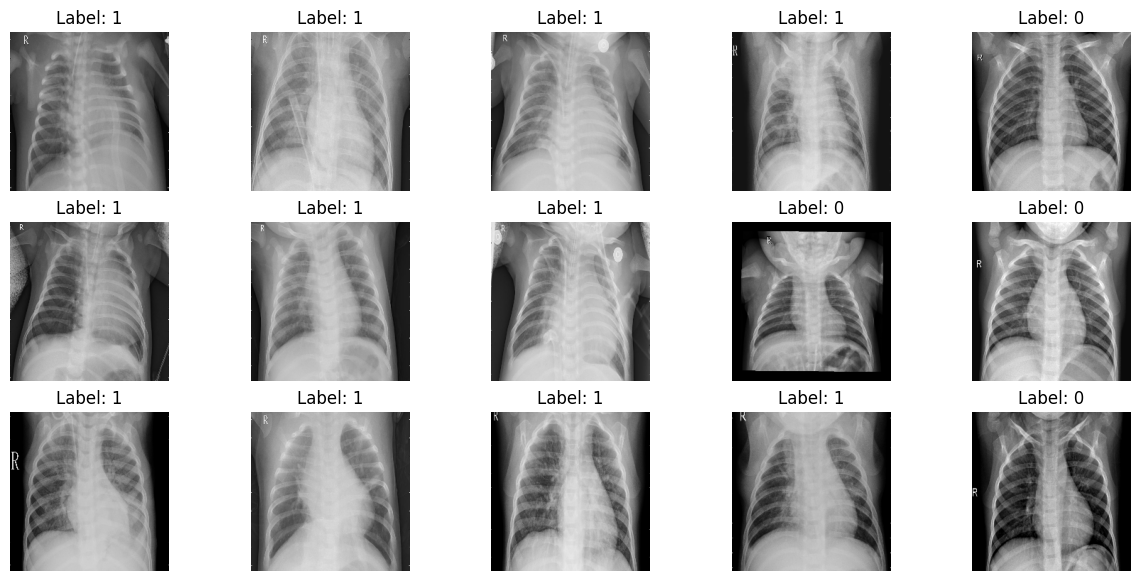

In [ ]:
# Retrieve a single batch from the training dataset
for images, labels in train_ds.take(1):
    # Visualize several images from the first batch
    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)  # Display images in a 3×5 grid
        # plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()


# **Model Development**

## *CNN + Data Augmentation (Color Jitter)*

In this session, we will build a Convolutional Neural Network (CNN) model and train it using data that has been augmented with color jitter to enhance variability and improve the model’s ability to generalize.

In [ ]:
input_shape = (224, 224, 3)

# Define the CNN model
model_1 = tf.keras.models.Sequential([
    Conv2D(32, (3, 3), strides=1, padding='valid', activation='relu', input_shape=input_shape),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(64, (3, 3), strides=1, padding='valid', activation='relu'),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(128, (3, 3), strides=1, padding='valid', activation='relu'),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Display the model summary
model_1.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,489,729 (9.50 MB)

 Trainable params: 2,489,729 (9.50 MB)

 Non-trainable params: 0 (0.00 B)

In this CNN architecture, we intentionally omit both padding and batch normalization to observe how the model performs without these additional stabilizing components.  


**Notes:**

*   In the context of neural network models, the value “None” in the model summary indicates a dimension that is undefined or variable at build time. This placeholder represents flexibility, allowing the model to accept inputs of varying sizes for that particular dimension.
*   The most common use of “None” appears in the batch size dimension. When defining a model, you typically do not need to specify a fixed batch size, as you may want the model to handle different batch sizes during training or inference. Setting the batch dimension to “None” ensures that the model can process batches of any size.

In [ ]:
# Set the learning rate
learning_rate = 0.07  # default is 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model using the specified optimizer
model_1.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy'
        # tf.keras.metrics.Recall(),
        # tf.keras.metrics.Precision()
    ]
)


After defining the CNN architecture, we adjust the learning rate for the training process. It is important to note that setting the learning rate too high may lead to gradient-related issues, often characterized by a stagnant model or a lack of improvement during training. If you encounter such gradient problems, it is advisable to reduce the learning rate to ensure more stable and effective optimization.

In [ ]:
checkpoint_filepath = '/tmp/checkpoint.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_filepath)

# Define the training callbacks
callbacks_1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),

    ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    )
]

Notes:

*   EarlyStopping: Monitors the val_loss at each epoch. Training will stop if the validation loss does not improve for three consecutive epochs. With restore_best_weights=True, the model’s weights are reverted to the best-performing state once training is halted.
*   ModelCheckpoint: Saves the model with the best performance based on val_loss. When save_best_only=True is enabled, the checkpoint is updated only when a new model outperforms the previous best.
*   ReduceLROnPlateau:  Reduces the learning rate when val_loss fails to improve for two consecutive epochs. The learning rate is scaled by a factor of 0.2, and min_lr=1e-7 sets the minimum allowable learning rate.
These callbacks help improve training efficiency, prevent overfitting, and ensure that the best version of the model is saved during the training process.  


Overall:  
These callbacks help improve training efficiency, prevent overfitting, and ensure that the best version of the model is saved during the training process.

In [ ]:
# Train the model using the training and validation datasets
history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks_1,
    verbose=1
)


Epoch 1/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 637s 5s/step - accuracy: 0.6870 - loss: 14239.9277 - val_accuracy: 0.7292 - val_loss: 0.5840 - learning_rate: 0.0700
Epoch 2/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 486s 4s/step - accuracy: 0.7366 - loss: 0.5776 - val_accuracy: 0.7292 - val_loss: 0.5846 - learning_rate: 0.0700
Epoch 3/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.7366 - loss: 0.5768 - val_accuracy: 0.7292 - val_loss: 0.5844 - learning_rate: 0.0700
Epoch 4/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.7366 - loss: 0.5765 - val_accuracy: 0.7292 - val_loss: 0.5840 - learning_rate: 0.0140
Epoch 5/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 445s 3s/step - accuracy: 0.7366 - loss: 0.5768 - val_accuracy: 0.7292 - val_loss: 0.5840 - learning_rate: 0.0140
Epoch 6/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 439s 3s/step - accuracy: 0.7366 - loss: 0.5767 - val_accuracy: 0.7292 - val_loss: 0.5840 - learning_rate: 0.0028
Epoch 7/200
129/129 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.7366

In [ ]:
def train_val_eval(history_name=None):
    """
    Extracts training and validation metrics from a Keras History object.

    Parameters:
        history_name (keras.callbacks.History):
            The History object returned by model.fit().

    Returns:
        tuple:
            - train_loss: Training loss values for each epoch
            - val_loss: Validation loss values for each epoch
            - train_acc: Training accuracy values for each epoch
            - val_acc: Validation accuracy values for each epoch
    """
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']

    return train_loss, val_loss, train_acc, val_acc


In [ ]:
def plot_training_history(history_name=None, start_epoch=1):
    """
    Plots the training and validation loss, accuracy, and learning rate
    across epochs using data from a Keras History object.

    Parameters:
        history_name (keras.callbacks.History):
            The History object returned by model.fit().
        start_epoch (int):
            The starting epoch index for the x‑axis in the plots.

    Raises:
        ValueError: If 'history_name' is not provided.
    """

    # Ensure that a valid History object is provided
    if history_name is None:
        raise ValueError("The 'history_name' parameter must be a valid History object.")

    # Extract training metrics
    train_loss, val_loss, train_acc, val_acc = train_val_eval(history_name)
    range_epoch = np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['learning_rate'] # Changed 'lr' to 'learning_rate'

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss', marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss', marker='x', color='blue')
    plt.plot(range_epoch, learning_rate, label='Learning Rate', marker='*', color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy', marker='o', color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy', marker='x', color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    plt.show()

In [ ]:
plot_training_history(history_name=history_1)

In [ ]:
# Load the best-performing model weights
model_1.load_weights(checkpoint_filepath)


In fact, loading the weights manually is unnecessary because the model is already using the best-performing weights. This is ensured by the early stopping callback, where we have set restore_best_weights=True.

In [ ]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model loss: {:5.2f}%".format(100 * loss))


We re-evaluate the model using the best-performing weights obtained during training.

In [ ]:
# Re-evaluate the model
evaluate(train_ds, model_1)


In [ ]:
# Evaluate the model on the validation dataset
evaluate(val_ds, model_1)

In [ ]:
# Evaluate the model on the test dataset
evaluate(test_ds, model_1)

In [ ]:
# List all files in the checkpoint directory
os.listdir(checkpoint_dir)

In [ ]:
# Clear the TensorFlow session after using the model
tf.keras.backend.clear_session()

In [ ]:
# Define a function to generate predictions and evaluate the model
def predict_and_evaluate(model, dataset):
    y_true = []  # Ground-truth labels
    y_pred = []  # Predicted labels

    # Iterate through the dataset to collect true labels and model predictions
    for image, label in dataset:
        predictions = model.predict(image, verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Generate a classification report
    report = classification_report(y_true, y_pred, target_names=['normal', 'pneumonia'])

    return report


In [ ]:
# Save the model
model_1.save('model_1.keras')

# Load the saved model
model_path = 'model_1.keras'
loaded_model_1 = tf.keras.models.load_model(model_path)

# Generate the classification report
classification_report_1 = predict_and_evaluate(loaded_model_1, test_ds)[0]

# Display the classification report
print(classification_report_1)


In [ ]:
def calculate_confusion_matrix(model, dataset):
    y_true = []  # Ground-truth labels
    y_pred = []  # Predicted labels

    # Iterate through the dataset to collect true labels and model predictions
    for image, label in dataset:
        predictions = model.predict(image, verbose=0)
        y_true.extend(label.numpy())
        y_pred.extend(np.round(predictions).flatten())

    # Compute the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=['Normal', 'Pneumonia'],
        yticklabels=['Normal', 'Pneumonia']
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Extract TP, FP, TN, and FN
    # Use ravel() or flatten() to obtain a one-dimensional array
    tn, fp, fn, tp = conf_matrix.ravel()

    return tp, fp, tn, fn


In [ ]:
# Compute the confusion matrix using the loaded model and the test dataset
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_1, test_ds)

# Display the results
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)


Next, we will create a function to manually calculate sensitivity (also known as True Positive Rate, TPR, or Recall) without using scikit‑learn. The calculation follows the formula:  
  
      Sensitivity = True Positive(TP) / True Positive(TP) + False Negative(FN)
It is important to note that sensitivity measures the model’s ability to correctly identify positive cases. This metric is particularly valuable in scenarios where False Negative errors may lead to serious consequences. A higher sensitivity value indicates that the model is more effective at detecting positive cases.


In [ ]:
def calculate_sensitivity(tp, fn):
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    return sensitivity

sensitivity = calculate_sensitivity(tp, fn)
print("Sensitivity (True Positive Rate):", sensitivity.round(2))


The value of Sensitivity is similar to the Recall metric shown in the classification report for the pneumonia class. For example, if the sensitivity is 0.96, we can interpret this as follows: out of 100 individuals who truly have pneumonia, the model successfully identifies 96 of them as positive, while 4 are incorrectly classified as negative (i.e., the model fails to detect their condition).

Next, we will calculate specificity, which measures the model’s ability to correctly identify true negative cases. Specificity can be computed using the following formula:  

      Specificity = True Negative(TN) / True Negative(TN) + False Positive(FP)
  
  Specificity provides insight into how well the model avoids making False Positive errors. A higher specificity indicates better performance in correctly identifying negative cases. Depending on the application and the potential consequences of misclassification, both sensitivity and specificity may be equally important.

In [ ]:
def calculate_specificity(tn, fp):
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return specificity

# Example usage with previously computed values
specificity = calculate_specificity(tn, fp)
print("Specificity (True Negative Rate):", specificity.round(2))


If the specificity is 0.86, this means that out of 100 individuals who do not actually have pneumonia, the model correctly identifies 86 of them as negative (not having pneumonia). However, 14 individuals who are truly negative are incorrectly classified as positive (pneumonia).

# CNN + Data Augmentation (Layers Augmentation)

In the augmentation layer that was created, the applied transformations include Random Zoom and Random Rotation. Both are configured with small zoom and rotation values to ensure that the augmented images remain clear, allowing the model to effectively recognize and learn the underlying visual patterns.

In [ ]:
# Create the training dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset_2 = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))

# Prepare the dataset with optional augmentation layers
train_ds_2 = prepare(
    train_dataset_2,
    batch_size,
    shuffle=False,
    layers_aug=True,
    custom_aug=False
)


In [ ]:
# Define the second CNN model architecture
model_2 = tf.keras.models.Sequential([
    # Input layer (implicitly defined by the first Conv2D layer)
    Conv2D(
        32, (3, 3),
        strides=1,
        padding='valid',
        activation='relu',
        input_shape=input_shape
    ),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(
        64, (3, 3),
        strides=1,
        padding='valid',
        activation='relu'
    ),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(
        64, (3, 3),
        strides=1,
        padding='valid',
        activation='relu'
    ),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Conv2D(
        128, (3, 3),
        strides=1,
        padding='valid',
        activation='relu'
    ),
    MaxPool2D((2, 2), strides=2, padding='valid'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification output
])


In this model, we use a learning rate of 0.001. This choice is made because larger learning rates (such as 0.01 or 0.05) can cause the model to show little to no improvement across epochs, potentially skipping over the optimal convergence point or even diverging entirely.

In [ ]:
# Set the learning rate
learning_rate = 0.05  # default is 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the specified optimizer
model_2.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Define the checkpoint path
checkpoint_filepath2 = '/tmp/checkpoint2'
checkpoint_dir2 = os.path.dirname(checkpoint_filepath2)

# Configure training callbacks
callbacks_1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_filepath2,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    )
]


In [ ]:
# Train the model using the prepared dataset and configured callbacks
history_2 = model_2.fit(
    train_ds_2,
    validation_data=val_ds,
    epochs=200,
    callbacks=callbacks_1
)


In [ ]:
# Plot the training and validation curves for the model
plot_training_history(history_name=history_2)

In [ ]:
# Evaluate the model on the training dataset
evaluate(train_ds, model_2)

In [ ]:
# Evaluate the model on the validation dataset
evaluate(val_ds, model_2)

In [ ]:
# Evaluate the model on the test dataset
evaluate(test_ds, model_2)

In [ ]:
# Save the trained model
model_2.save('model_2.keras')

# Load the saved model
model_path = 'model_2.keras'
loaded_model_2 = tf.keras.models.load_model(model_path)

# Generate the classification report
classification_report_2 = predict_and_evaluate(loaded_model_2, test_ds)

# Display the classification report
print(classification_report_2)

In [ ]:
# Compute the confusion matrix using the loaded model and the test dataset
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_2, test_ds)

# Display the results
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

After training the second model, its performance turned out to be lower than that of the first model. Therefore, it is preferable not to use the augmentation layer and instead rely solely on color jitter.

In [ ]:
tf.keras.backend.clear_session()

# CNN (Batch Normalization & padding) + Data Augmentation (Color Jitter)

In [ ]:
# Define the third CNN model architecture
model_3 = tf.keras.models.Sequential([
    # Input layer (implicitly defined by the first Conv2D layer)
    Conv2D(
        32, (3, 3),
        strides=1,
        padding='same',
        activation='relu',
        input_shape=input_shape
    ),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),

    Conv2D(
        64, (3, 3),
        strides=1,
        padding='same',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),

    Conv2D(
        64, (3, 3),
        strides=1,
        padding='same',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),

    Conv2D(
        128, (3, 3),
        strides=1,
        padding='same',
        activation='relu'
    ),
    BatchNormalization(),
    MaxPool2D((2, 2), strides=2, padding='same'),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Binary classification output
])

# Display the model summary
model_3.summary()


In [ ]:
# Set the learning rate
learning_rate = 0.1  # default is 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model using the specified optimizer
model_3.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Define the checkpoint path for model_3
checkpoint_filepath3 = '/tmp/checkpoint3'
checkpoint_dir3 = os.path.dirname(checkpoint_filepath3)

# Configure the training callbacks
callbacks_1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_filepath3,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    )
]


Next, during training, we will use train_ds, which is the dataset that has been augmented using the color_jitter function.

In [ ]:
history_3= model_3.fit(train_ds, validation_data=val_ds,
            epochs=200,
            callbacks=callbacks_1, verbose=1)

In [ ]:
plot_training_history(history_name=history_3)

In [ ]:
# Load the best saved weights for model_3
model_3.load_weights(checkpoint_filepath3)

In [ ]:
# Re‑evaluate the model on the validation dataset
evaluate(val_ds, model_3)

In [ ]:
# Re‑evaluate the model on the test dataset
evaluate(test_ds, model_3)

In [ ]:
# Clear the TensorFlow session after using the model
tf.keras.backend.clear_session()

In [ ]:
# Save the trained model
model_3.save('model_3.keras')

# Load the saved model
model_path = 'model_3.keras'
loaded_model_3 = tf.keras.models.load_model(model_path)

# Generate the classification report
classification_report_3 = predict_and_evaluate(loaded_model_3, test_ds)

# Display the classification report
print(classification_report_3)


In [ ]:
# Compute the confusion matrix using the loaded model and the test dataset
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_3, test_ds)

# Display the results
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)

In [ ]:
# Calculate and display the specificity (True Negative Rate)
specificity_model3 = calculate_specificity(tn, fp)
print("Specificity (True Negative Rate):", specificity_model3.round(2))

# Calculate and display the sensitivity (True Positive Rate)
sensitivity_model3 = calculate_sensitivity(tp, fn)
print("Sensitivity (True Positive Rate):", sensitivity_model3.round(2))

# Transfer Learning (VGG16)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D


**Note:**  

Global Average Pooling is a technique used to reduce the spatial dimensions of feature maps. In this approach, each channel is compressed into a single value by computing its average. This significantly reduces the number of parameters in the model, helping to prevent overfitting while still preserving the most relevant information from each feature channel.

In [ ]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of VGG16
model_4 = tf.keras.Sequential()
model_4.add(base_model)
# model_4.add(GlobalAveragePooling2D())  # Optional alternative to Flatten
model_4.add(Flatten())
model_4.add(Dense(198, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation='sigmoid'))

# Freeze all layers in the pre-trained base model (use existing weights without retraining)
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
model_4.summary()

In the model above, we use Flatten() because, based on our experiments, it produced better test performance compared to GlobalAveragePooling2D(). Although Flatten() tends to increase the risk of overfitting due to the larger number of parameters, the overall test score was still higher when using this layer, making it the more effective choice for this particular setup.

In [ ]:
# Set the learning rate
learning_rate = 0.07  # default is 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model using the specified optimizer
model_4.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In the transfer learning model, we will experiment with a higher learning rate compared to the previous models. The goal is to accelerate the optimization process, especially since the pre‑trained layers are frozen and only the newly added layers require training.

In [ ]:
# Define the checkpoint path for model_4
checkpoint_filepath4 = '/tmp/checkpoint4'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath4)

# Configure the training callbacks
callbacks_1 = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath=checkpoint_filepath4,
        monitor='val_loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=1e-7
    )
]


In [ ]:
# Train model_4 using the training and validation datasets
history_4 = model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks_1,
    verbose=1
)


In [ ]:
plot_training_history(history_name=history_4)

In [ ]:
model_4.load_weights(checkpoint_filepath4)

evaluate(val_ds,model_4)

In [ ]:
evaluate(train_ds,model_4)

In [ ]:
evaluate(test_ds,model_4)

In [ ]:
model_4.save('model_4.keras')

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Load the saved model
loaded_model_4 = tf.keras.models.load_model('model_4.keras')

# Generate the classification report
classification_report_result = predict_and_evaluate(loaded_model_4, test_ds)

# Display the classification report
print(classification_report_result)


In [ ]:
# Compute the confusion matrix using the loaded model and the test dataset
tp, fp, tn, fn = calculate_confusion_matrix(loaded_model_4, test_ds)

# Display the results
print("True Positive (TP):", tp)
print("False Positive (FP):", fp)
print("True Negative (TN):", tn)
print("False Negative (FN):", fn)


In [ ]:
specificity_model4 = calculate_specificity(tn, fp)
print("Specificity (True Negative Rate):", specificity_model4.round(2))

sensitivity_model4 = calculate_sensitivity(tp, fn)
print("Sensitivity (True Positive Rate):", sensitivity_model4.round(2))

The training results using VGG‑16 show a higher accuracy score compared to the previous models. In addition, both the false positive (FP) and false negative (FN) values are lower, indicating that the model performs better in correctly identifying both classes.

# Transfer Learning (Xception)

In [ ]:
from tensorflow.keras.applications import Xception

In [ ]:
# Load the pre-trained Xception model without the Fully Connected (top) layers
base_model_xception = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of the Xception base
model_5 = tf.keras.Sequential()
model_5.add(base_model_xception)
# model_5.add(GlobalAveragePooling2D())  # Optional alternative to Flatten
model_5.add(Flatten())
model_5.add(Dense(198, activation='relu'))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(1, activation='sigmoid'))

# Freeze all pre-trained layers to prevent them from being retrained
for layer in base_model_xception.layers:
    layer.trainable = False

# Display the model summary
model_5.summary()


In [ ]:
# Set the learning rate
learning_rate = 0.1  # default is 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model using the specified optimizer
model_5.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)
